In [1]:
import sys

sys.path.append("/home/olivier/PycharmProjects/bayesian-kst/")  # for ubuntu
from kgraph.expert_layer.domain_graph import DomainGraph
from kgraph.expert_layer.knowledge_components import KnowledgeComponent, ProceduralKnowledgeComponent
from kgraph.expert_layer.links import LinkModel, LinkFromParents, LinkFromChildren
from kgraph.resources_layer.exercise_family import ExerciseFamily
from kgraph.resources_layer.exercise import Exercise
from kgraph.learner_layer.evaluation import Evaluation
from kgraph.learner_layer.learner_pool import LearnerPool
from kgraph.learner_layer.learner import Learner, LearnerGraph
from kgraph.helpers.truthtable import truthtable
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn

## Mise en oeuvre du modèle général dont on cherche les paramètres

In [2]:
def get_two_dbn(domain_graph):
    knowledge_components = domain_graph.get_knowledge_components()
    twodbn = gum.BayesNet()
    
    for kc in knowledge_components:
        twodbn.add(gum.LabelizedVariable(f"{kc.name}0",f"{kc.name}0",2))
        twodbn.add(gum.LabelizedVariable(f"{kc.name}t",f"{kc.name}t",2))
        twodbn.addArc(f"{kc.name}0",f"{kc.name}t")
    for kc in knowledge_components:
        for parent in domain_graph.get_kc_parents(kc):
            twodbn.addArc(f"{parent.name}t",f"{kc.name}t")
        
    # à généraliser
    twodbn.cpt("A0").fillWith([.8,.2])
    twodbn.cpt("B0").fillWith([.8,.2])
    twodbn.cpt("At")[{'A0': 0}] = [.8, .2]
    twodbn.cpt("At")[{'A0': 1}] = [0, 1]
    twodbn.cpt("Bt")[{'B0': 0, 'At': 0}] = [1, 0]
    twodbn.cpt("Bt")[{'B0': 0, 'At': 1}] = [0.7, 0.3]
    twodbn.cpt("Bt")[{'B0': 1, 'At': 0}] = [0.6, 0.4]
    twodbn.cpt("Bt")[{'B0': 1, 'At': 1}] = [0, 1]
        
        
    return twodbn

In [3]:
# we define the KCs
KC_A = ProceduralKnowledgeComponent(1, "A")
KC_B = ProceduralKnowledgeComponent(2, "B")

# we define the link between the two that gonna lead to the link model
link_a_to_b = LinkFromParents(KC_B, [KC_A], [.4, .6])
link_b_to_a = LinkFromChildren(KC_A, [KC_B], [.1, .9])
link_model = LinkModel([link_a_to_b, link_b_to_a])

domain_graph = DomainGraph([KC_A, KC_B], link_model)

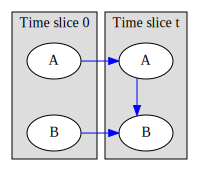

In [4]:
twodbn = get_two_dbn(domain_graph)
gdyn.showTimeSlices(twodbn)

## Application du modèle général sur le cas particulier d'un apprenant

In [5]:
# default params
params = {"slip": .1, "guess":.25}

# we define the exercises that corresponds to KC_A
ex_A_1 = Exercise(1, "qcm", ex_content="", params=params)
ex_A_2 = Exercise(2, "qcm", ex_content="", params=params)
ex_A_3 = Exercise(3, "qcm", ex_content="", params=params)
ex_A_4 = Exercise(4, "qcm", ex_content="", params=params)
ex_A_5 = Exercise(5, "qcm", ex_content="", params=params)

ex_fam_A = ExerciseFamily(1, "ex_fam_A", KC_A, [ex_A_1, ex_A_2, ex_A_3, ex_A_4, ex_A_5])

# we define the exercises that corresponds to KC_A
ex_B_1 = Exercise(6, "qcm", ex_content="", params=params)
ex_B_2 = Exercise(7, "qcm", ex_content="", params=params)
ex_B_3 = Exercise(8, "qcm", ex_content="", params=params)
ex_B_4 = Exercise(9, "qcm", ex_content="", params=params)
ex_B_5 = Exercise(10, "qcm", ex_content="", params=params)

ex_fam_B = ExerciseFamily(1, "ex_fam_B", KC_B, [ex_B_1, ex_B_2, ex_B_3, ex_B_4, ex_B_5])


learner_pool = LearnerPool(domain_graph)
learner_pool.setup_random_learners(1000)
n_evals = 3000
sim_evaluations = learner_pool.simulate_evaluations_from_learners(n_evals)
temp_eval = []
for i in range(len(sim_evaluations)):
    temp = []
    for evaluation in sim_evaluations[i]:
        temp += [(evaluation.get_kc(), int(evaluation.answers[key]["success"])) for key in list(evaluation.answers.keys())]
    temp_eval.append(temp)
sim_evaluations=temp_eval

In [15]:
def get_learner_dbn(twodbn, learner_evals):
    slip=.1
    guess=.25
    evidences = {}
    print(learner_evals)
    for i in range(len(learner_evals)):
        print(f"Evaluation #{i} on KC {learner_evals[i][0].name}: {'success' if learner_evals[i][1] else 'fail'}")
        evidences[f"{learner_evals[i][0].name}{i+1}"] = int(learner_evals[i][1])
        #evidences[f"{learner_evals[i][0].name}{i+1}"] = [guess, 1-guess] if learner_evals[i][1] else [1-slip, slip]
    print(evidences)
    gdyn.plotFollow(["A","B"],twodbn,T=len(learner_evals)+1,evs=evidences)
    
get_learner_dbn(twodbn, sim_evaluations[0])

[(<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x7fc6fecfc9a0>, 1), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x7fc6fecfc9a0>, 0), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x7fc6fecfc9a0>, 1), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x7fc6fecfc9a0>, 1), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x7fc6fecfc9a0>, 1), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x7fc6fecfc910>, 0), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x7fc6fecfc910>, 1), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x7fc6fecfc910>, 1), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x7fc6fecfc910>, 0), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent 

Exception: [pyAgrum] Several evidence/CPT are incompatible together (proba=0): some evidence entered into the Bayes net are incompatible (their joint proba = 0)